# LOGISTIC REGRESSION #

## INITIAL CONFIGURATION ##

In [1]:
import os
import numpy as np
import pandas as pd
import collections
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from my_functions import *

In [2]:
file_path = (os.path.dirname(os.getcwd()) + '/data/')
data = pd.read_csv(file_path + '/Bank_Customer_Churn_Prediction.csv')

## DATA PREPROCESSING ##

In [3]:
data.drop(columns="customer_id",axis=1,inplace=True)
data['country'] = data['country'].map({'France': 0, 'Spain' : 1,'Germany':2})
data['gender'] = data['gender'].map({'Male': 0, 'Female' : 1})
data['balance'] = data['balance'].astype('int64')
data['estimated_salary'] = data['estimated_salary'].astype('int64')
data.to_csv(file_path+'preprocessed_data.csv')


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   credit_score      10000 non-null  int64
 1   country           10000 non-null  int64
 2   gender            10000 non-null  int64
 3   age               10000 non-null  int64
 4   tenure            10000 non-null  int64
 5   balance           10000 non-null  int64
 6   products_number   10000 non-null  int64
 7   credit_card       10000 non-null  int64
 8   active_member     10000 non-null  int64
 9   estimated_salary  10000 non-null  int64
 10  churn             10000 non-null  int64
dtypes: int64(11)
memory usage: 859.5 KB


In [5]:
data.isnull().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [6]:
y = data['churn']
X = data.drop(columns='churn', axis = 1)

In [7]:
X.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,0,1,42,2,0,1,1,1,101348
1,608,1,1,41,1,83807,1,0,1,112542
2,502,0,1,42,8,159660,3,1,0,113931
3,699,0,1,39,1,0,2,0,0,93826
4,850,1,1,43,2,125510,1,1,1,79084


In [8]:
np.random.seed(0)
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(collections.Counter(y_resampled).items()))

[(0, 7963), (1, 7963)]


C:\Users\Teresa\AppData\Local\Temp\ipykernel_21260\2992105325.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn', data=dataframe,alpha=0.8,palette='pastel')


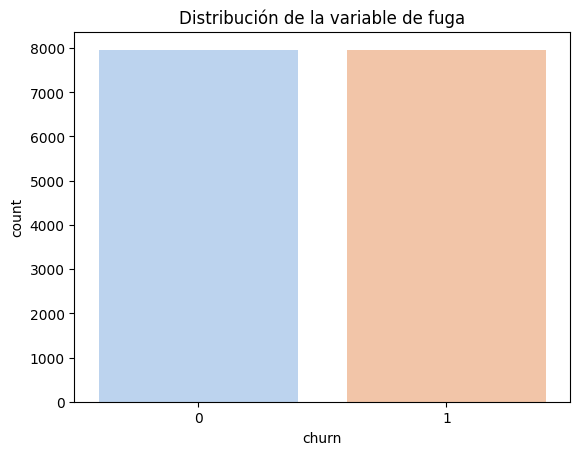

In [9]:
dataframe = pd.DataFrame(y_resampled)
sns.countplot(x='churn', data=dataframe,alpha=0.8,palette='pastel')
plt.title('Distribución de la variable de fuga')
plt.show()

In [10]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [11]:
np.random.seed(0)
sc= StandardScaler()
X_train_rescaled = sc.fit_transform(X_train)
X_test_rescaled = sc.transform(X_test)

In [12]:
print(X_train_rescaled.mean())
print(X_test_rescaled.mean())
print(X_train_rescaled.std())
print(X_test_rescaled.std())

-2.3870666476085e-17
0.01429811034464932
1.0
1.0083331886545412


## MODEL ##

### Fine-tuning ###

In [13]:

np.random.seed(0)
### Hyper-parameter tuning with Grid Search method.
param_grid = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}

cv = KFold(n_splits=10, random_state=None, shuffle=True)
clf_model = GridSearchCV(LogisticRegression(penalty='l2',random_state=42,solver='lbfgs'),param_grid,cv=cv, n_jobs=1, verbose=1)
clf_model = clf_model.fit(X_train_rescaled,y_train)

print ('Acuracy for LogisticRegressionCV with BEST C is: {0}. The success rate is: {1}:'.format(
    clf_model.best_params_['C'], clf_model.best_score_))


Fitting 10 folds for each of 6 candidates, totalling 60 fits
Acuracy for LogisticRegressionCV with BEST C is: 0.1. The success rate is: 0.7392464678178966:


### Train with Cross Validation ###

In [14]:
np.random.seed(0)
#cross-validation
cv = KFold(n_splits=10, random_state=None, shuffle=True)
train_scores = cross_validate(LogisticRegression(penalty='l2', C=0.1, random_state=42,solver='lbfgs'), X_train_rescaled, y_train,cv=cv, scoring=('accuracy', 'precision','recall','f1'),
                        return_train_score=True)

mean_accuracy = train_scores['test_accuracy'].mean()
mean_precision = train_scores['test_precision'].mean()
mean_recall = train_scores['test_recall'].mean()
mean_f1 = train_scores['test_f1'].mean()

print('Mean accuracy:', mean_accuracy)
print('Mean precision:', mean_precision)
print('Mean recall:', mean_recall)
print('Mean F1 score:', mean_f1)

Mean accuracy: 0.7392464678178966
Mean precision: 0.7313648333711347
Mean recall: 0.761986567383777
Mean F1 score: 0.7461450988431921


In [15]:
np.random.seed(0)
model_lr = LogisticRegression(penalty='l2', C=0.001, random_state=42,solver='lbfgs')
model_lr.fit(X_train_rescaled,y_train)
y_pred = model_lr.predict(X_test_rescaled)

### Evaluation ###

In [16]:
"""accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)"""

'accuracy = accuracy_score(y_test,y_pred)\nprecision = precision_score(y_test, y_pred)\nrecall = recall_score(y_test, y_pred)\nf1 = f1_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\nprint("Precision:", precision)\nprint("Recall:", recall)\nprint("F1-score:", f1)'

### How many times was the classifier correct on the train set? ###

In [17]:
np.random.seed(0)
y_pred_train = model_lr.predict(X_train_rescaled)
# Find residual differences between train data and predicted train data
residuals = np.abs(y_train - y_pred_train)
# Print value counts of our predicted values 
print(pd.Series(residuals).value_counts())
print('----------------------------------')
# Print normalized value counts of our predicted values
print(pd.Series(residuals).value_counts(normalize = True))

churn
0    9424
1    3316
Name: count, dtype: int64
----------------------------------
churn
0    0.739717
1    0.260283
Name: proportion, dtype: float64


### How many times was the classifier correct on the test set? ###

In [18]:
np.random.seed(0)
y_pred_test = model_lr.predict(X_test_rescaled)
# Find residual differences between train data and predicted train data
residuals = np.abs(y_test - y_pred_test)
# Print value counts of our predicted values 
print(pd.Series(residuals).value_counts())
print('----------------------------------')
# Print normalized value counts of our predicted values
print(pd.Series(residuals).value_counts(normalize = True))

churn
0    2413
1     773
Name: count, dtype: int64
----------------------------------
churn
0    0.757376
1    0.242624
Name: proportion, dtype: float64


In [19]:
np.random.seed(0)
# Call confusion_matrix function from sklearn.metrics using actual y_test and predicted y_test data sets 
cnf_matrix = confusion_matrix(y_test, y_pred_test, labels=model_lr.classes_)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1200  433]
 [ 340 1213]]


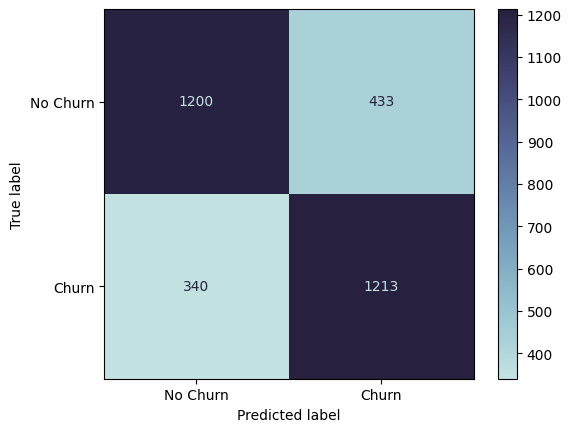

In [20]:
np.random.seed(0)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['No Churn', 'Churn'])
disp.plot(cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

In [21]:
np.random.seed(0)
metrics(y_train, y_pred_train, y_test, y_pred_test)

Training Metrics:


Training Accuracy:  0.7397174254317112
Training Precision:  0.7310334528076463
Training Recall:  0.7636505460218409
Training F1-Score:  0.7469861132305814


Testing Metrics:
Testing Accuracy:  0.7573760200878845
Testing Precision:  0.7369380315917375
Testing Recall:  0.7810688989053445
Testing F1-Score:  0.7583619881212879




([0.7397174254317112,
  0.7310334528076463,
  0.7636505460218409,
  0.7469861132305814],
 [0.7573760200878845,
  0.7369380315917375,
  0.7810688989053445,
  0.7583619881212879])

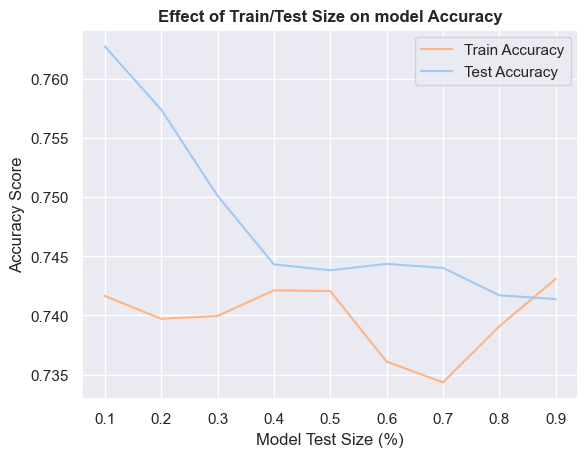

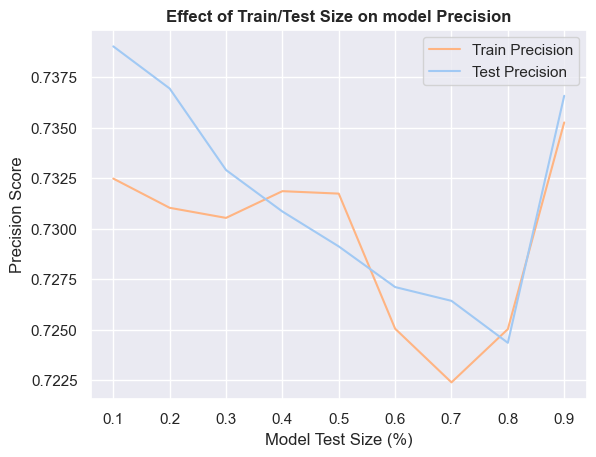

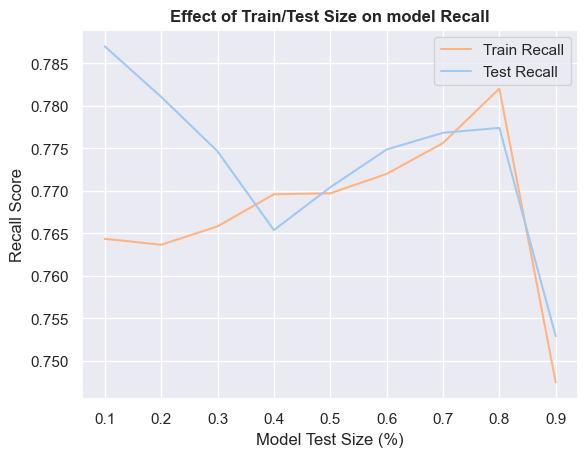

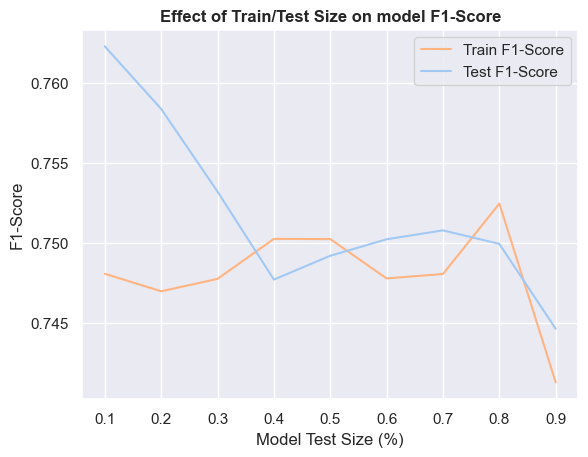

In [25]:
sns.set_theme(style="darkgrid")
print_metric_plots(X_resampled,y_resampled)

c:\TFG\TFG_ADE\modelos\my_functions.py:137: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--',color='#aaa')


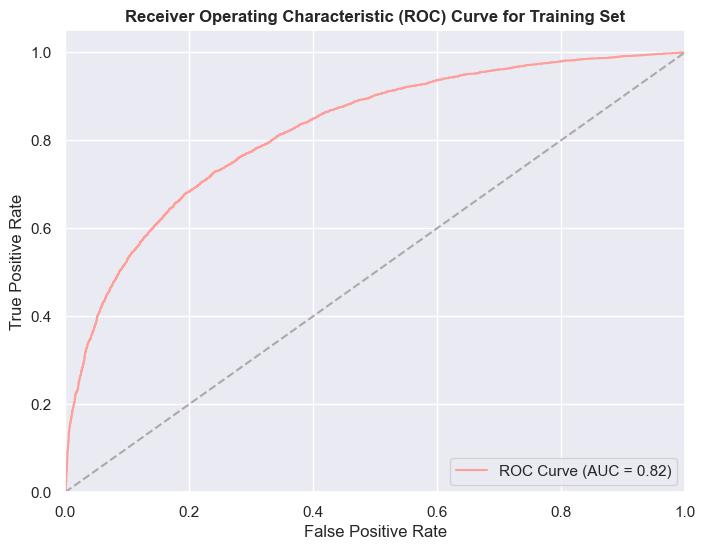

c:\TFG\TFG_ADE\modelos\my_functions.py:153: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'k--',color='#aaa')


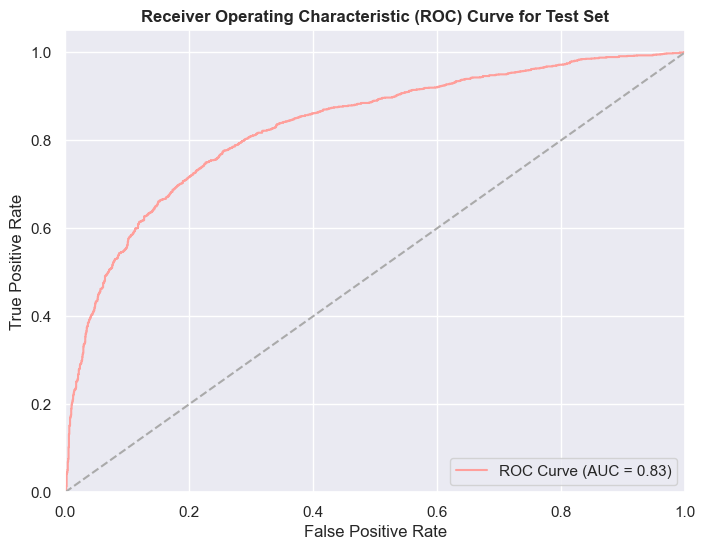

In [24]:
sns.set_theme(style="darkgrid")
roc(X_resampled, y_resampled)